### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

### Load And Inspect Data

In [2]:
df = pd.read_csv("AMZN_stock_data.csv")
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,1997-05-15 00:00:00-04:00,0.121875,0.125000,0.096354,0.097917,1443120000,0.0,0.0
1,1997-05-16 00:00:00-04:00,0.098438,0.098958,0.085417,0.086458,294000000,0.0,0.0
2,1997-05-19 00:00:00-04:00,0.088021,0.088542,0.081250,0.085417,122136000,0.0,0.0
3,1997-05-20 00:00:00-04:00,0.086458,0.087500,0.081771,0.081771,109344000,0.0,0.0
4,1997-05-21 00:00:00-04:00,0.081771,0.082292,0.068750,0.071354,377064000,0.0,0.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6987 entries, 0 to 6986
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          6987 non-null   object 
 1   Open          6987 non-null   float64
 2   High          6987 non-null   float64
 3   Low           6987 non-null   float64
 4   Close         6987 non-null   float64
 5   Volume        6987 non-null   int64  
 6   Dividends     6987 non-null   float64
 7   Stock Splits  6987 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 436.8+ KB


In [4]:
df.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,6987.000000,6987.000000,6987.000000,6987.000000,6.987000e+03,6987.0,6987.000000
mean,40.692696,41.165619,40.178290,40.685061,1.360552e+08,0.0,0.003864
std,58.144182,58.787641,57.435304,58.125169,1.375735e+08,0.0,0.244286
min,0.070313,0.072396,0.065625,0.069792,9.744000e+06,0.0,0.000000
25%,2.100250,2.148250,2.064250,2.110000,6.298900e+07,0.0,0.000000
50%,9.041500,9.158500,8.925000,9.021000,1.005360e+08,0.0,0.000000
75%,72.789249,73.643497,71.504250,73.006500,1.555070e+08,0.0,0.000000
max,239.020004,242.520004,238.029999,242.059998,2.086584e+09,0.0,20.000000


In [5]:
df.isnull().sum()

Date            0
Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64

In [6]:
df.duplicated().sum()

np.int64(0)

In [7]:
df.shape

(6987, 8)

In [8]:
for i, col in enumerate(df.columns, 1):
    dtype = df[col].dtype
    unique = df[col].nunique()
    print(f"{i:2}. {col:<15} | Type: {str(dtype):<10} | Unique Values: {unique}")

 1. Date            | Type: object     | Unique Values: 6987
 2. Open            | Type: float64    | Unique Values: 6246
 3. High            | Type: float64    | Unique Values: 6204
 4. Low             | Type: float64    | Unique Values: 6208
 5. Close           | Type: float64    | Unique Values: 6343
 6. Volume          | Type: int64      | Unique Values: 6792
 7. Dividends       | Type: float64    | Unique Values: 1
 8. Stock Splits    | Type: float64    | Unique Values: 4


### Preprocessing

In [9]:
df['Date'] = pd.to_datetime(df['Date'], utc=True)

In [10]:
df['Date'] = df['Date'].dt.tz_localize(None)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6987 entries, 0 to 6986
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          6987 non-null   datetime64[ns]
 1   Open          6987 non-null   float64       
 2   High          6987 non-null   float64       
 3   Low           6987 non-null   float64       
 4   Close         6987 non-null   float64       
 5   Volume        6987 non-null   int64         
 6   Dividends     6987 non-null   float64       
 7   Stock Splits  6987 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 436.8 KB


In [12]:
df['Date'].head()

0   1997-05-15 04:00:00
1   1997-05-16 04:00:00
2   1997-05-19 04:00:00
3   1997-05-20 04:00:00
4   1997-05-21 04:00:00
Name: Date, dtype: datetime64[ns]

In [13]:
df = df.sort_values('Date')

In [14]:
df = df.drop(columns=['Dividends', 'Stock Splits'])

In [15]:
df.tail()

,Date,Open,High,Low,Close,Volume
6982,2025-02-14 05:00:00,229.199997,229.889999,227.229996,228.679993,27031100
6983,2025-02-18 05:00:00,228.820007,229.300003,223.720001,226.649994,42975100
6984,2025-02-19 05:00:00,225.520004,226.830002,223.710007,226.630005,28566700
6985,2025-02-20 05:00:00,224.779999,225.130005,221.809998,222.880005,30001700
6986,2025-02-21 05:00:00,223.279999,223.309998,214.740005,216.580002,55161000


#### Create the Target Variable (Next-Day Close Price)

In [16]:
df['Target_Close'] = df['Close'].shift(-1)
df = df.dropna().reset_index(drop=True)

#### Feature Engineering (Moving Average)

In [17]:
df['MA_10'] = df['Close'].rolling(window=10).mean()
df = df.dropna().reset_index(drop=True)

#### Select Features and Target

In [18]:
X = df[['Open', 'High', 'Low', 'Volume', 'MA_10']]
y = df['Target_Close']

In [19]:
X.head()

,Open,High,Low,Volume,MA_10
0,0.077083,0.077083,0.073958,69456000,0.079870
1,0.075000,0.075521,0.073958,51888000,0.077578
2,0.075521,0.076563,0.075000,11832000,0.076485
3,0.076563,0.076563,0.073958,23664000,0.075339
4,0.073958,0.074479,0.069792,61608000,0.074245


In [20]:
y.head()

0    0.075000
1    0.075521
2    0.073958
3    0.070833
4    0.077083
Name: Target_Close, dtype: float64

#### Train–Test Split (Time-Series Safe)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

## Linear Regression Model

#### Train Linear Regression Model

In [22]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


#### Predict & Evaluate (Linear Regression)

In [23]:
lr_pred = lr_model.predict(X_test)

lr_mae = mean_absolute_error(y_test, lr_pred)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))

print("Linear Regression MAE:", lr_mae)
print("Linear Regression RMSE:", lr_rmse)

Linear Regression MAE: 2.2691120771781246
Linear Regression RMSE: 3.100669892156327


## Random Forest Model

#### Train Random Forest Model

In [24]:
rf_model = RandomForestRegressor(
    n_estimators=100,
    random_state=42
)
rf_model.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


#### Predict & Evaluate (Random Forest)

In [25]:
rf_pred = rf_model.predict(X_test)

rf_mae = mean_absolute_error(y_test, rf_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))

print("Random Forest MAE:", rf_mae)
print("Random Forest RMSE:", rf_rmse)

Random Forest MAE: 46.77763619070408
Random Forest RMSE: 57.89965934280028


#### Compare Models

In [26]:
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest'],
    'MAE': [lr_mae, rf_mae],
    'RMSE': [lr_rmse, rf_rmse]
})

results

,Model,MAE,RMSE
0,Linear Regression,2.269112,3.100670
1,Random Forest,46.777636,57.899659


#### Visualization

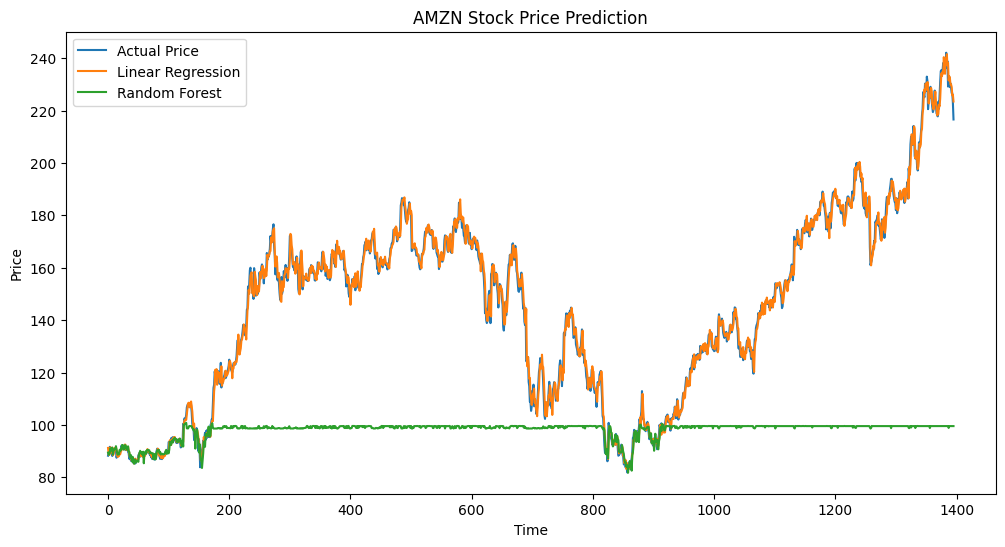

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(y_test.values, label='Actual Price')
plt.plot(lr_pred, label='Linear Regression')
plt.plot(rf_pred, label='Random Forest')
plt.legend()
plt.title("AMZN Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("Price")
plt.show()

## LSTM

#### Prepare Data for LSTM

In [28]:
close_data = df[['Close']].values

#### Scale the Data

In [29]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(close_data)

#### Create Sequences (Time Steps)

In [30]:
X_lstm = []
y_lstm = []

for i in range(60, len(scaled_data)):
    X_lstm.append(scaled_data[i-60:i, 0])
    y_lstm.append(scaled_data[i, 0])

X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

#### Reshape Data for LSTM

In [31]:
X_lstm = X_lstm.reshape((X_lstm.shape[0], X_lstm.shape[1], 1))

#### Train–Test Split

In [32]:
split = int(0.8 * len(X_lstm))

X_train_lstm = X_lstm[:split]
X_test_lstm = X_lstm[split:]

y_train_lstm = y_lstm[:split]
y_test_lstm = y_lstm[split:]

#### Build LSTM Model

In [33]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

#### Train the LSTM Model

In [34]:
model.fit(
    X_train_lstm,
    y_train_lstm,
    epochs=10,
    batch_size=32,
    verbose=1
)

Epoch 1/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 27s 120ms/step - loss: 2.4531e-04
Epoch 2/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 21s 121ms/step - loss: 2.9013e-05
Epoch 3/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 20s 117ms/step - loss: 2.8110e-05
Epoch 4/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 21s 120ms/step - loss: 2.5985e-05
Epoch 5/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 19s 107ms/step - loss: 2.3877e-05
Epoch 6/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 14s 83ms/step - loss: 2.3945e-05
Epoch 7/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 15s 85ms/step - loss: 2.1491e-05
Epoch 8/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 16s 90ms/step - loss: 2.2754e-05
Epoch 9/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 16s 90ms/step - loss: 2.2596e-05
Epoch 10/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 16s 90ms/step - loss: 2.0378e-05


#### Predict Using LSTM

In [35]:
lstm_pred = model.predict(X_test_lstm)

44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step


#### Inverse Scale Predictions

In [36]:
lstm_pred = scaler.inverse_transform(lstm_pred.reshape(-1,1))
y_test_actual = scaler.inverse_transform(y_test_lstm.reshape(-1,1))

#### Evaluate LSTM

In [37]:
lstm_rmse = np.sqrt(mean_squared_error(y_test_actual, lstm_pred))
print("LSTM RMSE:", lstm_rmse)

LSTM RMSE: 7.850210234023731


#### Visualize LSTM Predictions

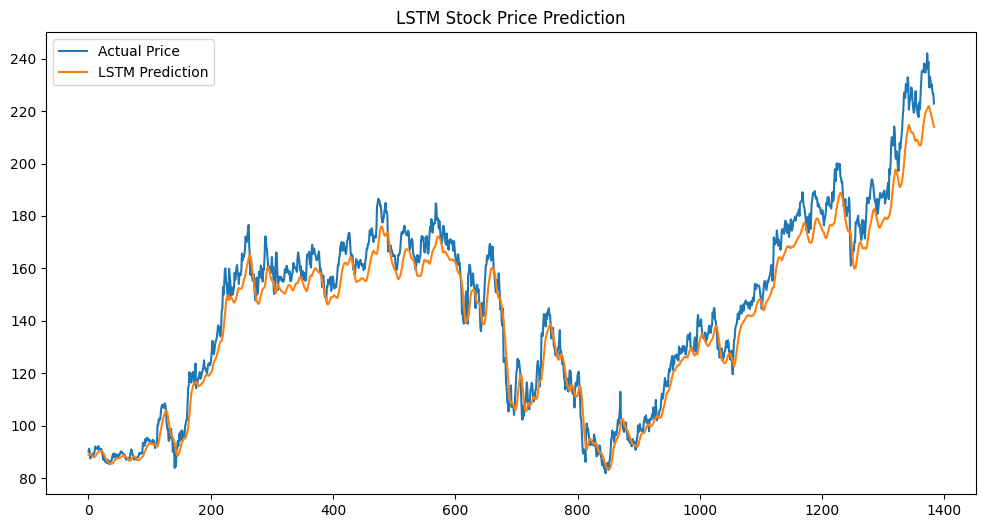

In [38]:
plt.figure(figsize=(12,6))
plt.plot(y_test_actual, label='Actual Price')
plt.plot(lstm_pred, label='LSTM Prediction')
plt.legend()
plt.title("LSTM Stock Price Prediction")
plt.show()

#### Predict Multiple Future Days

In [39]:
future_days = 10

last_60_days = scaled_data[-60:]
future_predictions = []

current_input = last_60_days.reshape(1, 60, 1)

for _ in range(future_days):
    next_price = model.predict(current_input)
    future_predictions.append(next_price[0,0])
    
    current_input = np.append(
        current_input[:,1:,:],
        [[[next_price[0,0]]]],
        axis=1
    )

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


#### Inverse Scale Future Predictions

In [40]:
future_predictions = scaler.inverse_transform(
    np.array(future_predictions).reshape(-1,1)
)
future_predictions

array([[212.78516],
       [210.42369],
       [207.60936],
       [204.60277],
       [201.54514],
       [198.51431],
       [195.55261],
       [192.68214],
       [189.9134 ],
       [187.25064]], dtype=float32)

## Future Predictions

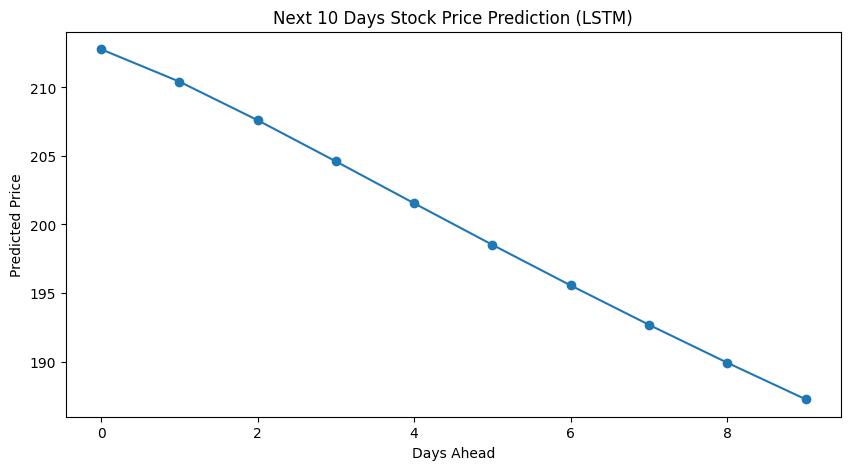

In [41]:
plt.figure(figsize=(10,5))
plt.plot(future_predictions, marker='o')
plt.title("Next 10 Days Stock Price Prediction (LSTM)")
plt.xlabel("Days Ahead")
plt.ylabel("Predicted Price")
plt.show()

## ML vs LSTM

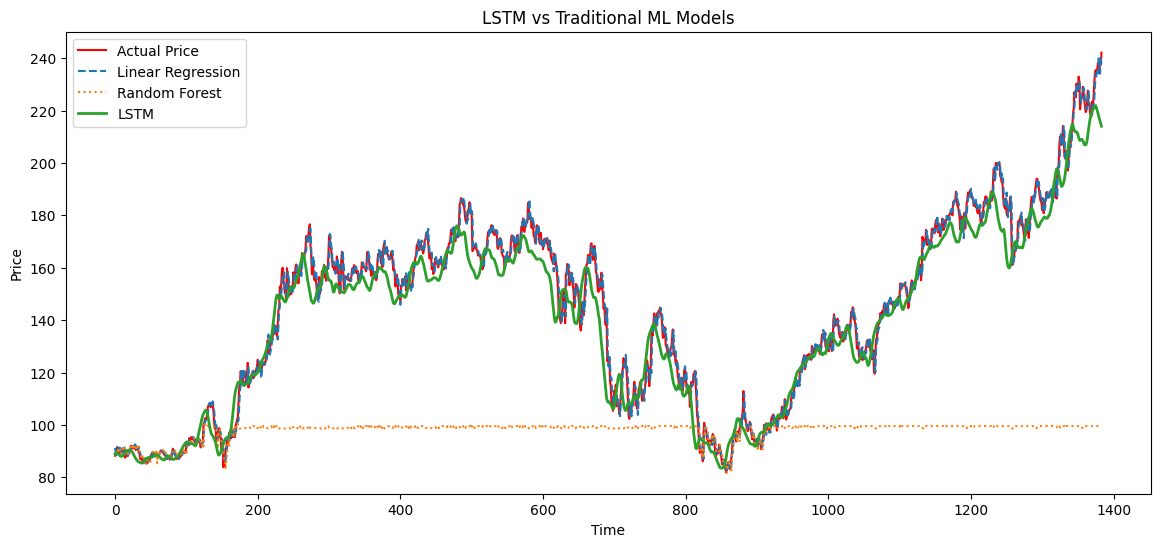

In [42]:
min_len = min(len(lr_pred), len(lstm_pred))

plt.figure(figsize=(14,6))

plt.plot(y_test.values[:min_len], label='Actual Price', color='red')
plt.plot(lr_pred[:min_len], label='Linear Regression', linestyle='--')
plt.plot(rf_pred[:min_len], label='Random Forest', linestyle=':')
plt.plot(lstm_pred[:min_len], label='LSTM', linewidth=2)

plt.title("LSTM vs Traditional ML Models")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

## Error Comparison (Visual RMSE Bar Chart)

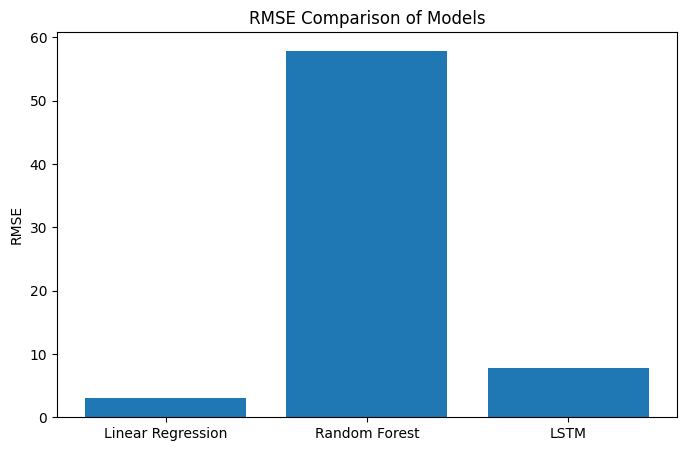

In [43]:
models = ['Linear Regression', 'Random Forest', 'LSTM']
rmse_values = [lr_rmse, rf_rmse, lstm_rmse]

plt.figure(figsize=(8,5))
plt.bar(models, rmse_values)
plt.title("RMSE Comparison of Models")
plt.ylabel("RMSE")
plt.show()

## Best Model

In [44]:
import pandas as pd

comparison_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'LSTM'],
    'RMSE': [lr_rmse, rf_rmse, lstm_rmse]
})

comparison_df

,Model,RMSE
0,Linear Regression,3.100670
1,Random Forest,57.899659
2,LSTM,7.850210


In [45]:
best_model = comparison_df.loc[comparison_df['RMSE'].idxmin()]

best_model

Model    Linear Regression
RMSE               3.10067
Name: 0, dtype: object

In [46]:
print(
    f"The best performing model is {best_model['Model']} "
    f"with the lowest RMSE of {best_model['RMSE']:.4f}"
)

The best performing model is Linear Regression with the lowest RMSE of 3.1007
